# Assignment 2: Monte Carlo (MC) Methods in Finance

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.stats as stats


## Part I Option Valuation

### Q1: Monte Carlo for European Call？ Options

#### Convergence Study

In [53]:
# Parameters
S0 = 100       # initial stock price
K = 99         # strike price
T = 1.0        # time to maturity
r = 0.06       # risk-free rate
sigma = 0.20   # volatility
M_trials = np.concatenate((np.arange(1000, 31000, 1000), np.arange(40000, 10010000, 10000)))

option_prices = []
std_errors = []

# Monte Carlo simulation to estimate European Option price
def monte_carlo_simulation(S0, K, T, r, sigma, M):
    dt = T / M  # time step
    discount_factor = np.exp(-r * T)  # discount factor for present value
    
    # Generate M stock price paths
    Z = np.random.standard_normal(M)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z) 
    payoffs = np.maximum(ST - K, 0)
    option_price = discount_factor * np.mean(payoffs)  # average discounted payoff
    std_error = discount_factor * np.std(payoffs) / np.sqrt(M)
    
    return option_price, std_error

for M in M_trials:
    optionPrices=[]
    stdErrors=[]
    price, error = monte_carlo_simulation(S0, K, T, r, sigma, M)
    optionPrices.append(price)
    stdErrors.append(error)
    option_prices.append(np.mean(optionPrices))
    std_errors.append(np.mean(stdErrors))
    
confidence_interval_widths = 1.96 * np.array(std_errors)
true_value = 11.544280227051097
a = np.where(confidence_interval_widths > 0.01)[0][-1]
print(M_trials[a])
print(option_prices[a])

8990000
11.55644801052583


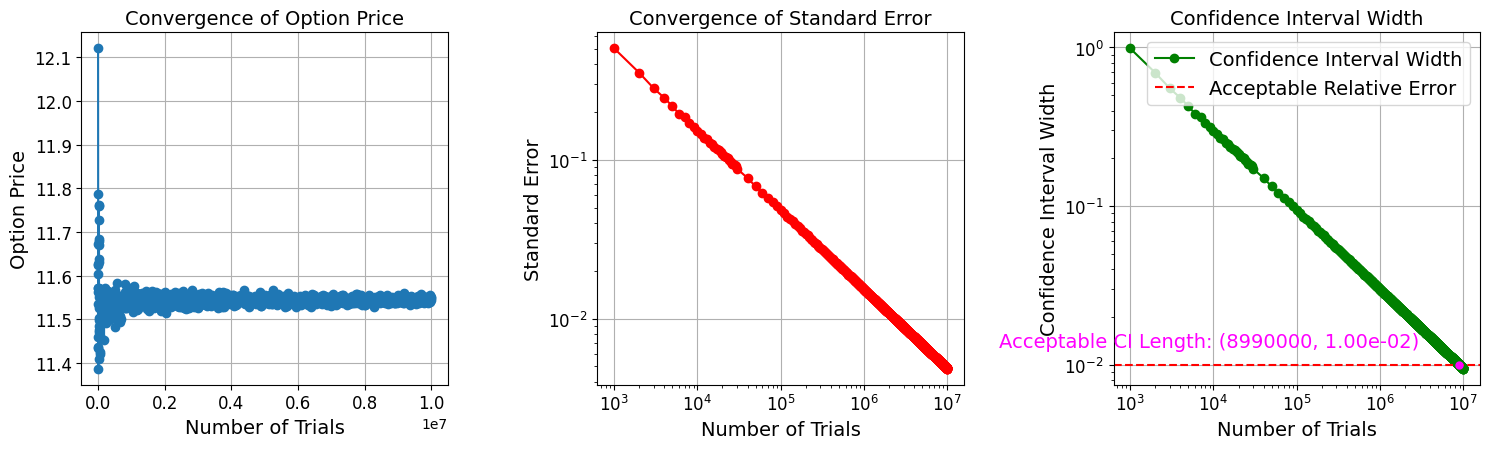

[12.120910273765146, 11.571118226660808, 11.671641158366292, 11.786159092375954, 11.534098997538102, 11.626138446699757, 11.562609996202518, 11.604533102790857, 11.624851027378195, 11.387165270925447, 11.434287805091603, 11.459562464117415, 11.572352387067566, 11.43743065690256, 11.57073027073967, 11.483796833805394, 11.52673015484324, 11.728391577489742, 11.670539467223277, 11.408634805157625, 11.476239713891838, 11.63789465098876, 11.760592156615658, 11.682979860533106, 11.630898315708912, 11.497755088748903, 11.760861639274074, 11.551256442239128, 11.679159844826215, 11.502488577743419, 11.470266858549238, 11.461525303904843, 11.419826904441543, 11.425457246174664, 11.560140243512002, 11.543919421336456, 11.5441273118572, 11.536893945973716, 11.503919874829522, 11.550619590218536, 11.567647882942579, 11.551517618552559, 11.549650719315213, 11.497301344993566, 11.453558009308859, 11.551969681881154, 11.571744154675988, 11.522137208092543, 11.558611308355516, 11.52767640448563, 11.491

In [54]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
# Option Price Convergence
ax1.plot(M_trials, option_prices, marker='o')
ax1.set_xlabel('Number of Trials', fontsize=14)
ax1.set_ylabel('Option Price', fontsize=14)
ax1.set_title('Convergence of Option Price', fontsize=14)
ax1.tick_params(labelsize=12)
ax1.grid(True)

# Standard Error Convergence
ax2.plot(M_trials, std_errors, marker='o', color='red')
ax2.set_xlabel('Number of Trials', fontsize=14)
ax2.set_ylabel('Standard Error', fontsize=14)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_title('Convergence of Standard Error', fontsize=14)
ax2.tick_params(labelsize=12)
ax2.grid(True)

# Confidence Interval Width
ax3.plot(M_trials, confidence_interval_widths, marker='o', color='green', label='Confidence Interval Width')
ax3.set_xlabel('Number of Trials', fontsize=14)
ax3.set_ylabel('Confidence Interval Width', fontsize=14)
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_title('Confidence Interval Width', fontsize=14)
ax3.axhline(y=0.01, color='r', linestyle='--', label='Acceptable Relative Error')
acceptable_ci_point = M_trials[a], confidence_interval_widths[a]
# Use bullet point to mark the acceptable CI length
ax3.annotate('Acceptable CI Length: ({}, {:.2e})'.format(*acceptable_ci_point),
             xy=acceptable_ci_point,
             xytext=(acceptable_ci_point[0] / 3, acceptable_ci_point[1]*1.3), 
             textcoords='data',
             ha='right',
             fontsize=14, 
             color='magenta')
ax3.plot(*acceptable_ci_point, 'o', color='magenta', markersize=5)
ax3.legend(fontsize=14)
ax3.tick_params(labelsize=12)
ax3.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('Figures/4.1.1OptionPriceConvergence.png', dpi = 500)
plt.show()
print(option_prices)

#### Varying Volality and Strike Price

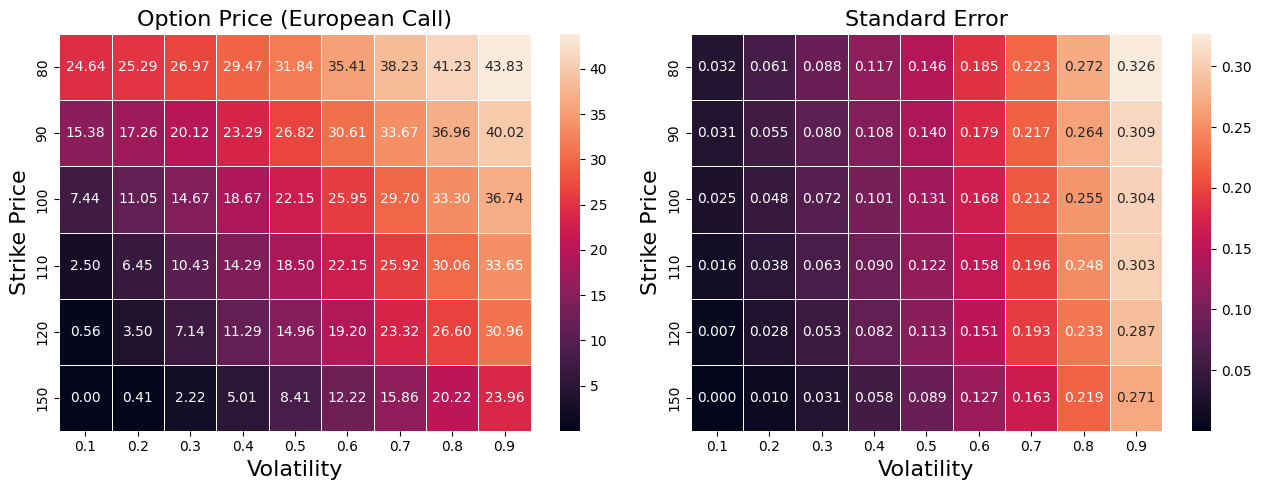

In [55]:
S0 = 100
T = 1.0 
r = 0.06
M = 100000    

strike_prices = [80, 90, 100, 110, 120,150]
volatilities = [0.1,0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Store the results
results = []

# Perform simulations for varying strike prices and volatilities
for K in strike_prices:
    for sigma in volatilities:
        price, error = monte_carlo_simulation(S0, K, T, r, sigma, M)
        results.append((K, sigma, price, error))

df = pd.DataFrame(results, columns=['Strike Price', 'Volatility', 'Option Price', 'Standard Error'])

pivot_price = df.pivot(index="Strike Price", columns="Volatility", values="Option Price")
pivot_error = df.pivot(index="Strike Price", columns="Volatility", values="Standard Error")

# Plotting heatmaps for Option Price and Standard Error
plt.figure(figsize=(13, 5))

plt.subplot(1, 2, 1)

sns.heatmap(pivot_price, annot=True, fmt=".2f", linewidths=0.5)
plt.xlabel("Volatility", fontsize=16)
plt.ylabel("Strike Price", fontsize=16)
plt.title("Option Price (European Call)", fontsize=16)

plt.subplot(1, 2, 2)
sns.heatmap(pivot_error, annot=True, fmt=".3f", linewidths=0.5)
plt.title("Standard Error", fontsize=16)
plt.xlabel("Volatility", fontsize=16)
plt.ylabel("Strike Price", fontsize=16)

plt.tight_layout()
plt.savefig('Figures/4.1.2OptionPriceHeatmap.png', dpi = 500)
plt.show()



### Q2: Heston stochastic volatility model

#### Implement the Heston stochastic volatility model using milstein method

In [56]:
def milstein_scheme_for_heston(T, K, B, r, kappa, theta, xi, rho, delta_t, paths, S0 = 100):
    n = 252
    S = np.zeros((paths, n+1))
    v = np.zeros((paths, n+1))
    S[:, 0] = S0
    v[:, 0] = theta

    barrier_hit = np.zeros(paths, dtype=bool)  # Keep track of paths that hit the barrier
    dw_v = np.random.normal(0, 1, (paths,n))
    dw_s = rho * dw_v + np.sqrt(1 - rho**2) * np.random.normal(0, 1, (paths,n))
    
    for t in range(1, n+1):
        
        v[:, t] = v[:, t-1] + kappa * (theta - np.maximum(v[:, t-1], 0)) * delta_t + xi * np.sqrt(np.maximum(v[:, t-1], 0)* delta_t) * dw_v[:, t-1] + \
                    0.25 * xi**2 * (dw_v[:, t-1]**2 - 1) * delta_t
        v[:, t] = np.maximum(v[:, t], 0)  # Take the positive part of the variance
        
        #S[:, t] = S[:, t-1] * (1 + r * delta_t + np.sqrt(np.maximum(v[:, t-1], 0)* delta_t) * dw_s[:, t-1] + \
         #           0.5 * v[:, t-1] * (dw_s[:, t-1]**2 - 1) * delta_t)
        S[:, t] = S[:, t-1] * np.exp((r - 0.5 * np.maximum(v[:, t-1], 0)) * delta_t + np.sqrt(np.maximum(v[:, t-1], 0) * delta_t) * dw_s[:, t-1])
                  
        # Mark paths that hit the barrier
        barrier_hit = np.logical_or(barrier_hit, S[:, t] >= B)

    payoffs = np.maximum(S[:, -1] - K, 0)
    payoffs[barrier_hit] = 0  # Exclude payoffs from paths that hit the barrier
    option_price = np.mean(payoffs) * np.exp(-r * T)
    std_error = np.std(payoffs) * np.exp(-r * T) / np.sqrt(paths)

    return S[:, -1], option_price, barrier_hit.sum(), std_error

1.6334865542112358 3798 0.037852606559961276
1.5275055749327964 19591 0.016382814988215404


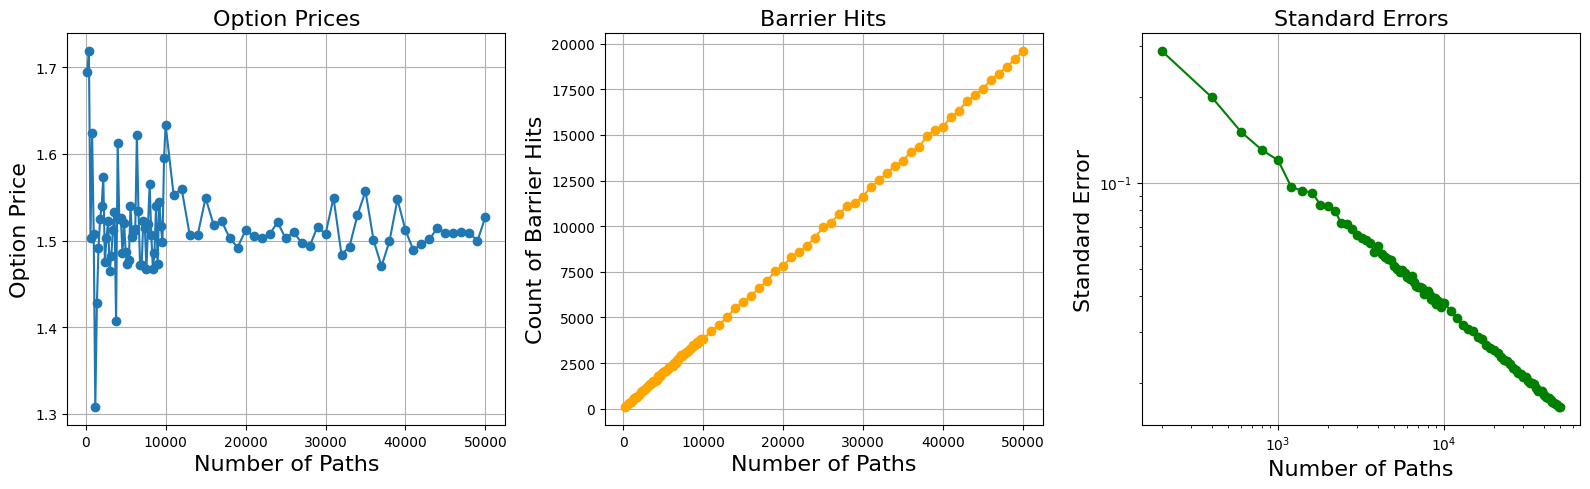

In [57]:
T = 1
K = 100
B = 120
r = 0.05
kappa = 2
theta = 0.04
xi = 0.1
rho = -0.7
delta_t = 1/252
S0 = 100

paths_range = np.concatenate((np.arange(200, 10200, 200), np.arange(11000, 51000, 1000)))
option_prices = []
barrier_hits = []
standard_errors = []
for paths in paths_range:
    S_T, option_price, barrier_hit, standard_error = milstein_scheme_for_heston(T, K, B, r, kappa, theta, xi, rho, delta_t, paths)
    option_prices.append(option_price)
    barrier_hits.append(barrier_hit)
    standard_errors.append(standard_error)
    if paths == 10000:
        print(option_price, barrier_hit, standard_error)
    elif paths == 50000:
        print(option_price, barrier_hit, standard_error)

fig, axs = plt.subplots(1, 3, figsize=(16, 5))

# Plot option prices
axs[0].plot(paths_range, option_prices, marker='o')
axs[0].set_title('Option Prices', fontsize=16)
axs[0].set_xlabel('Number of Paths', fontsize=16)
axs[0].set_ylabel('Option Price', fontsize=16)
axs[0].grid(True)

# Plot barrier hits
axs[1].plot(paths_range, barrier_hits, marker='o', color='orange')
axs[1].set_title('Barrier Hits', fontsize=16)
axs[1].set_xlabel('Number of Paths', fontsize=16)
axs[1].set_ylabel('Count of Barrier Hits', fontsize=16)
axs[1].grid(True)
# Plot standard errors
axs[2].plot(paths_range, standard_errors, marker='o', color='green')
axs[2].set_title('Standard Errors', fontsize=16)
axs[2].set_xlabel('Number of Paths', fontsize=16)
axs[2].set_ylabel('Standard Error', fontsize=16)
axs[2].set_yscale('log')
axs[2].set_xscale('log')
axs[2].grid(True)

plt.tight_layout()
plt.savefig('Figures/4.2.1HestonOptionPriceConvergence.png', dpi = 500)


#### Varying parameters： the barrier B, correlation ρ and the vol-of-vol ξ parameters.

In [58]:
T = 1 
K = 100
B = 120
r = 0.05 
kappa = 2
theta = 0.04
xi = 0.1
xi_range = np.arange(0.1, 1, 0.1)
rho = -0.7
rho_range = np.arange(-0.9, 1, 0.2)
B_range = np.arange(120, 320, 20)
delta_t = 1/252
paths = 10000
S0 = 100 

option_prices_xi_rho = np.zeros((len(rho_range), len(xi_range)))


for i, rh in enumerate(rho_range):
    for j, x in enumerate(xi_range):
        _, option_price, _, _ = milstein_scheme_for_heston(T, K, B, r, kappa, theta, x, rh, delta_t, paths, S0)
        option_prices_xi_rho[i, j] = option_price

option_prices_B_rho = np.zeros((len(rho_range), len(B_range)))

for i, rh in enumerate(rho_range):
    for j, b in enumerate(B_range):
        _, option_price, _, _ = milstein_scheme_for_heston(T, K, b, r, kappa, theta, xi, rh, delta_t, paths, S0)
        option_prices_B_rho[i, j] = option_price

option_prices_xi_B = np.zeros((len(B_range), len(xi_range)))

for i, b in enumerate(B_range):
    for j, x in enumerate(xi_range):
        _, option_price, _, _ = milstein_scheme_for_heston(T, K, b, r, kappa, theta, x, rho, delta_t, paths, S0)
        option_prices_xi_B[i, j] = option_price




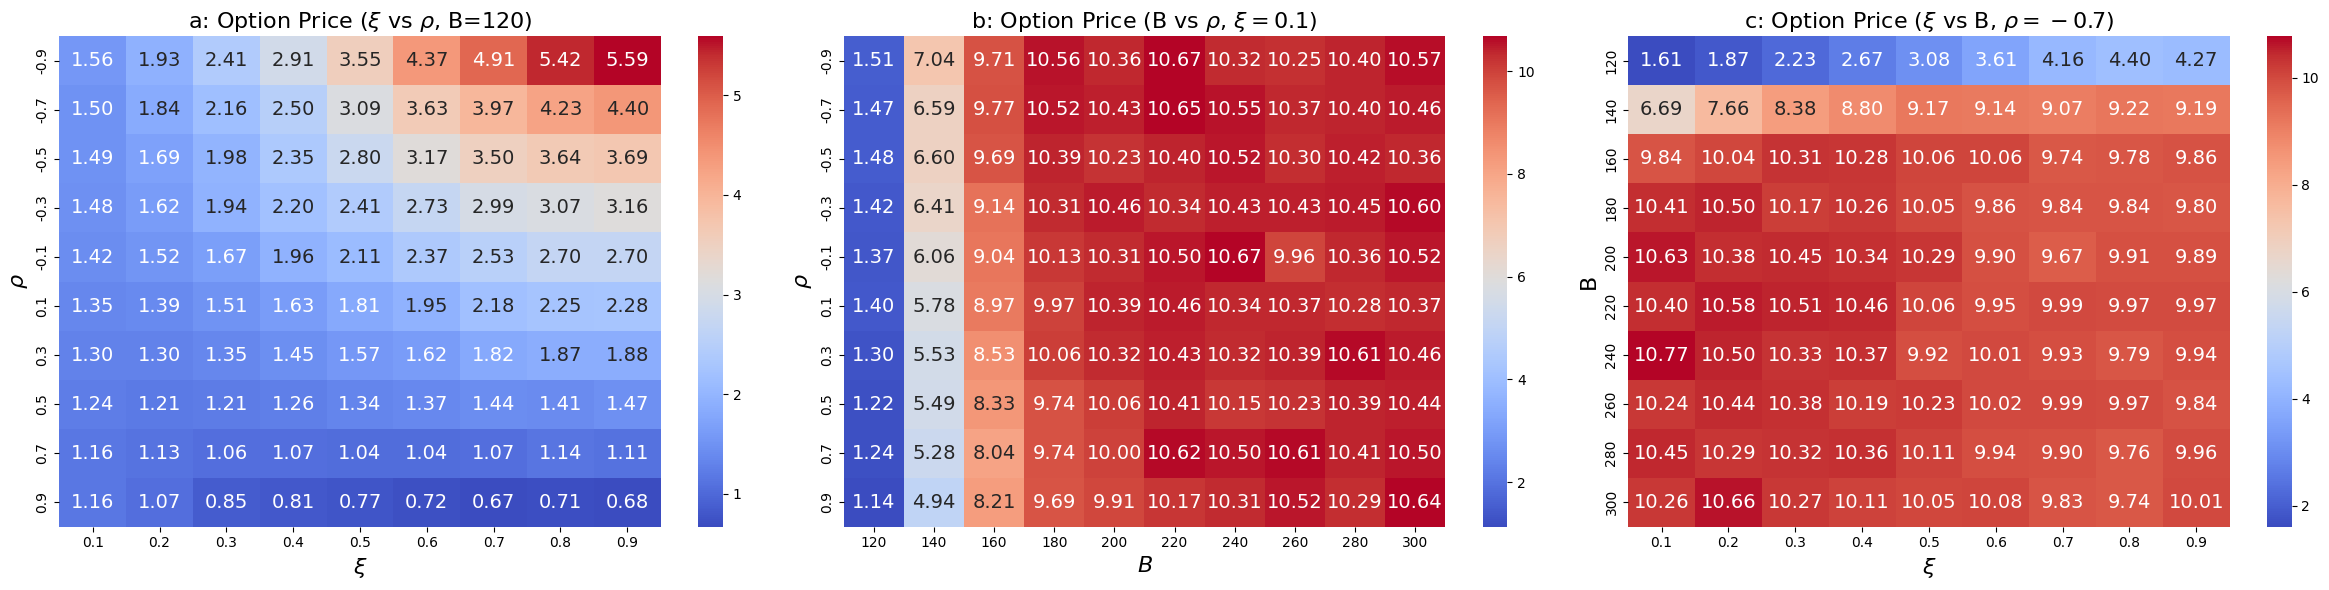

In [59]:
fig, axes = plt.subplots(1, 3, figsize=(24, 6))
annot_kws = {'size': 14}
sns.heatmap(option_prices_xi_rho, ax=axes[0], annot=True, fmt=".2f", xticklabels=np.round(xi_range, 2), yticklabels=np.round(rho_range, 2), cmap='coolwarm', annot_kws=annot_kws)
axes[0].set_title(fr'a: Option Price ($\xi$ vs $\rho$, B=120)', fontsize=16)
axes[0].set_xlabel(r'$\xi$', fontsize=16)
axes[0].set_ylabel(r'$\rho$', fontsize=16)

sns.heatmap(option_prices_B_rho, ax=axes[1], annot=True, fmt=".2f", xticklabels=np.round(B_range, 2), yticklabels=np.round(rho_range, 2), cmap='coolwarm', annot_kws=annot_kws)
axes[1].set_title(fr'b: Option Price (B vs $\rho$, $\xi=0.1$)', fontsize=16)
axes[1].set_xlabel(r'$B$', fontsize=16)
axes[1].set_ylabel(r'$\rho$', fontsize=16)

sns.heatmap(option_prices_xi_B, ax=axes[2], annot=True, fmt=".2f", xticklabels=np.round(xi_range, 2), yticklabels=np.round(B_range, 2), cmap='coolwarm', annot_kws=annot_kws)
axes[2].set_title(fr'c: Option Price ($\xi$ vs B, $\rho=-0.7$)', fontsize=16)
axes[2].set_xlabel(r'$\xi$', fontsize=16)
axes[2].set_ylabel('B', fontsize=16)

plt.tight_layout()
plt.savefig('Figures/4.2.2HestonOptionPriceHeatmap.png', dpi = 500)
plt.show()

##### Variying B

In [60]:
T = 1 
K = 100
B = 105
B_range = np.concatenate((np.arange(90, 101, 2), np.arange(101, 405, 5)))
r = 0.05 
kappa = 2
theta = 0.04
xi = 0.1
xi_range = np.linspace(0.01, 0.99, 100)
rho = -0.7
rho_range = np.linspace(-0.99, 0.99, 100)
delta_t = 1/252
paths = 10000
S0 = 100 
xi_list = [0.1, 0.5, 0.9]
rho_list = [-0.7, 0, 0.7]
B_list = [100, 102, 105, 120]
plt.figure(figsize=(16, 5))
for i, rh in enumerate(rho_list):
    plt.subplot(1, 3, i+1)
    for x in xi_list:
        option_prices_B = []
        for b in B_range:
            _, option_price, _, _ = milstein_scheme_for_heston(T, K, b, r, kappa, theta, x, rh, delta_t, paths)
            option_prices_B.append(option_price)
        plt.plot(B_range, option_prices_B, marker='o', label=fr'$\xi = {x}$')  # Use f-string for label
        plt.title(fr'$\rho = {rh}$', fontsize=16)
        plt.legend(fontsize=14)

        plt.xlabel('Barrier Level B', fontsize=16)
        plt.ylabel('Option Price', fontsize=16)
        plt.ylim(0,15)

plt.tight_layout()
plt.savefig('Figures/4.2.2.1VaryingB.png', dpi = 500)
plt.show()

#### Option Price Sensitivity Analysis

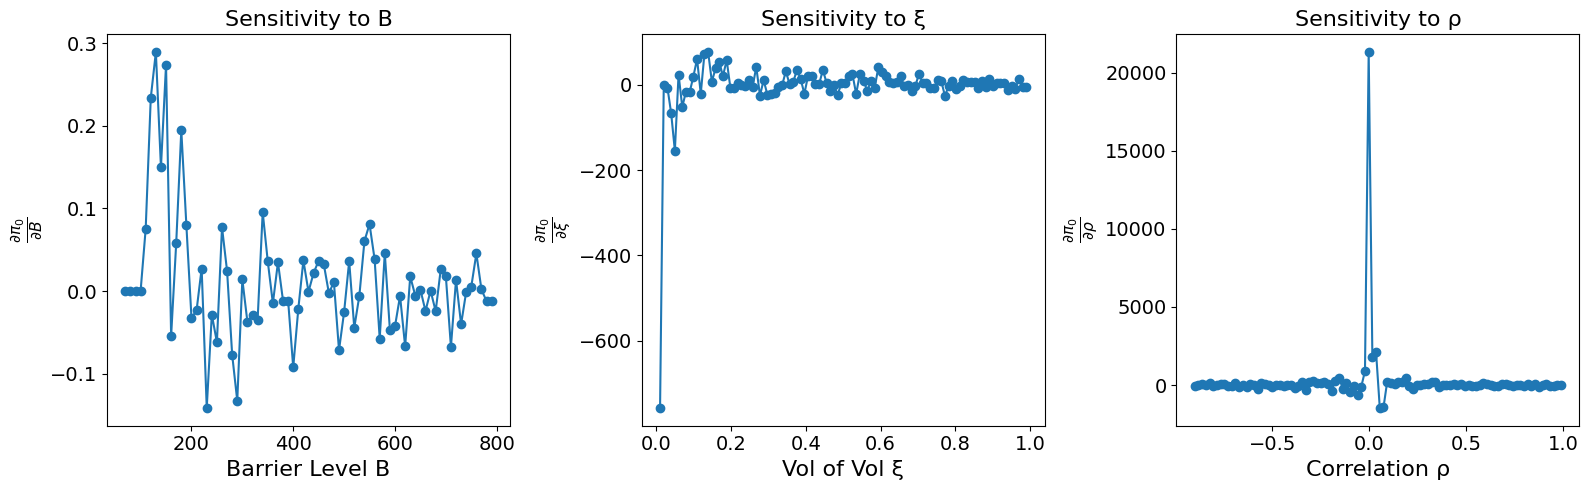

In [ ]:
T = 1
K = 100
B = 120
r = 0.05
kappa = 2
theta = 0.04
xi = 0.1
rho = -0.7
delta_t = 1/252
paths = 10000
S0 = 100
xi_range = np.linspace(0.01, 0.99, 100)
rho_range = np.linspace(-0.9, 0.99, 100)
B_range = np.arange(70, 800, 10)
dT = 1/252  

sensitivities_B = []
sensitivities_xi = []
sensitivity_rhos = []

for b in B_range:
    # Calculate the original option price
    _, option_price_original, _, _ = milstein_scheme_for_heston(T, K, b, r, kappa, theta, xi, rho, delta_t, paths)
    # Sensitivity to B
    _, option_price_bumped_B, _, _ = milstein_scheme_for_heston(T, K, b * 1.01, r, kappa, theta, xi, rho, delta_t, paths)
    sensitivity_B = (option_price_bumped_B - option_price_original) / (b * 0.01)
    sensitivities_B.append(sensitivity_B)

for x in xi_range:
    _, option_price_original, _, _ = milstein_scheme_for_heston(T, K, B, r, kappa, theta, x, rho, delta_t, paths)
    _, option_price_bumped_xi, _, _ = milstein_scheme_for_heston(T, K, B, r, kappa, theta, x * 1.01, rho, delta_t, paths)
    sensitivity_xi = (option_price_bumped_xi - option_price_original) / (x * 0.01)
    sensitivities_xi.append(sensitivity_xi)
    
for rh in rho_range:
    _, option_price_original, _, _ = milstein_scheme_for_heston(T, K, B, r, kappa, theta, xi, rh, delta_t, paths)
    _, option_price_bumped_rho, _, _= milstein_scheme_for_heston(T, K, B, r, kappa, theta, xi, rh * 1.001, delta_t, paths)
    sensitivity_rho = (option_price_bumped_rho - option_price_original) / (rh * 0.001)
    sensitivity_rhos.append(sensitivity_rho)
    

# Create 1x3 subplot for each Greek
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
axes[0].plot(B_range, sensitivities_B, marker='o')
axes[0].set_title('Sensitivity to B', fontsize=16)
axes[0].set_xlabel('Barrier Level B', fontsize=16)
axes[0].set_ylabel(r'$\frac{\partial \pi_0}{\partial B}$', fontsize=16)
axes[0].tick_params(labelsize=14)


axes[1].plot(xi_range, sensitivities_xi, marker='o')
axes[1].set_title('Sensitivity to ξ', fontsize=16)
axes[1].set_xlabel('Vol of Vol ξ', fontsize=16)
axes[1].set_ylabel(r'$\frac{\partial \pi_0}{\partial \xi}$', fontsize=16)
axes[1].tick_params(labelsize=14)

axes[2].plot(rho_range, sensitivity_rhos, marker='o')
axes[2].set_title('Sensitivity to ρ', fontsize=16)
axes[2].set_xlabel('Correlation ρ', fontsize=16)
axes[2].set_ylabel(r'$\frac{\partial \pi_0}{\partial \rho}$', fontsize=16)
axes[2].tick_params(labelsize=14)

plt.tight_layout()
plt.savefig('Figures/4.2.3Greeks.png', dpi = 500)



## Part II Estimation of Sensitivities in MC

### Q1: Use bump-and-revalue method to estimate delta

In [ ]:
# Bump-and-revalue method to estimate Delta
def bump_and_revalue(S0, K, T, r, sigma, N, seed=np.random.seed(), bump_size=0.01):
    # Monte Carlo simulation to estimate the option price for original and bumped S0
    def simulate_option_price(S0, r, sigma, T, N, n_simulations=10000):
        dt = T / N
        prices = np.zeros(n_simulations)
        for i in range(n_simulations):
            # Simulate the asset price path
            dW = np.random.normal(scale=np.sqrt(dt), size=N)
            path = S0 * np.cumprod(np.exp((r - 0.5 * sigma ** 2) * dt + sigma * dW))
            # Calculate the payoff for a European call option
            payoff = max(path[-1] - K, 0)
            prices[i] = payoff
        # Discount the average payoff to get the option price
        option_price = np.exp(-r * T) * np.mean(prices)
        return option_price

    # Calculate the option price for unbumped S0
    np.random.seed(seed)
    price_unbumped = simulate_option_price(S0, r, sigma, T, N)

    # Bump the underlying asset price
    S0_bumped = S0 + S0 * bump_size

    # Calculate the option price for bumped S0 with the same random seed
    np.random.seed(seed)  # Use the same seed for reproducibility
    price_bumped_same_seed = simulate_option_price(S0_bumped, r, sigma, T, N)

    # Reset the seed and calculate the option price for bumped S0 with a different seed
    np.random.seed()  # Use a different seed
    price_bumped_diff_seed = simulate_option_price(S0_bumped, r, sigma, T, N)

    # Estimate Delta using the same seed
    delta_same_seed = (price_bumped_same_seed - price_unbumped) / (S0 * bump_size)

    # Estimate Delta using a different seed
    delta_diff_seed = (price_bumped_diff_seed - price_unbumped) / (S0 * bump_size)

    return delta_same_seed, delta_diff_seed

# Given parameters
S0 = 100 
T = 1.0 
N = 200 
K = 99 
r = 0.06 
sigma = 0.2 
seeds = np.arange(101)

deltas_same_seed = []
deltas_diff_seed = []
for seed in seeds:
    # Calculate Delta with the bump-and-revalue method
    delta_same_seed, delta_diff_seed = bump_and_revalue(S0, K, T, r, sigma, N, seed)
    deltas_same_seed.append(delta_same_seed)
    deltas_diff_seed.append(delta_diff_seed)    

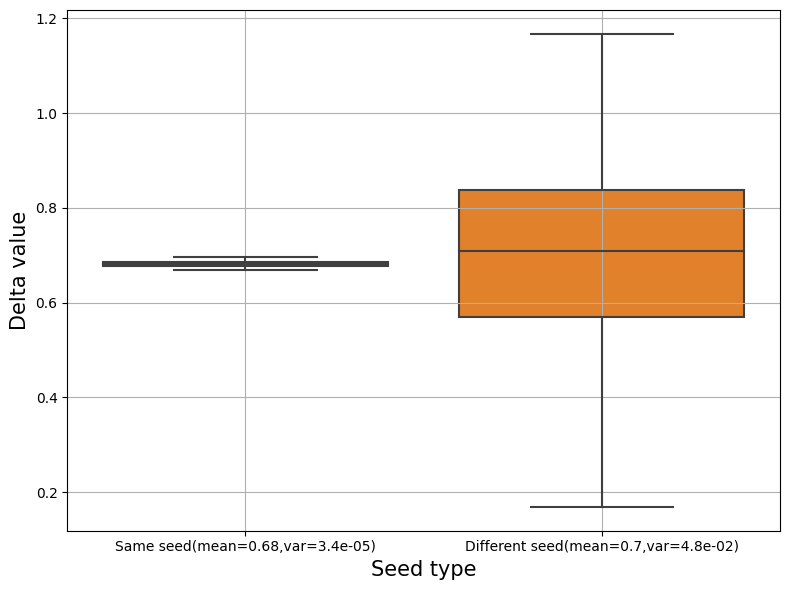

Result under 100 simulation round
For Same seed : mean = 0.6821830610655061, variance = 3.367637719116393e-05
For Different seed : mean = 0.7047101812081795, variance = 0.04750066023761862


In [ ]:
# Data adjust
var_same = format(np.var(deltas_same_seed), ".1e")
var_diff = format(np.var(deltas_diff_seed), ".1e")
# Box-plot
data = {f'Same seed(mean={round(np.mean(deltas_same_seed),2)},var={var_same})': deltas_same_seed, 
        f'Different seed(mean={round(np.mean(deltas_diff_seed),2)},var={var_diff})': deltas_diff_seed}
data_long_format = pd.DataFrame(list(data.items()), columns=['Seed type', 'Delta value']).explode('Delta value')
data_long_format['Delta value'] = data_long_format['Delta value'].astype(float)

plt.figure(figsize=(8, 6))
sns.boxplot(x='Seed type', y='Delta value', data=data_long_format)
#plt.title('Comparison of using same or different seed (Bumpsize = 0.01)', fontsize = 16)
plt.xlabel('Seed type', fontsize = 15)
plt.ylabel('Delta value', fontsize = 15)
plt.grid(True)

plt.tight_layout()
plt.savefig('Figures/4.2.1 seed(init).png', dpi = 500)

plt.show()

print("Result under 100 simulation round")
print(f"For Same seed : mean = {np.mean(deltas_same_seed)}, variance = {np.var(deltas_same_seed)}")
print(f"For Different seed : mean = {np.mean(deltas_diff_seed)}, variance = {np.var(deltas_diff_seed)}")

Experiment with Different Bump Sizes

Try different `bump sizes` and compare the results in `AS1`.

Results in AS1:
- With the same parameter settings as in `AS1`, we obtain **Delta**: `0.674`


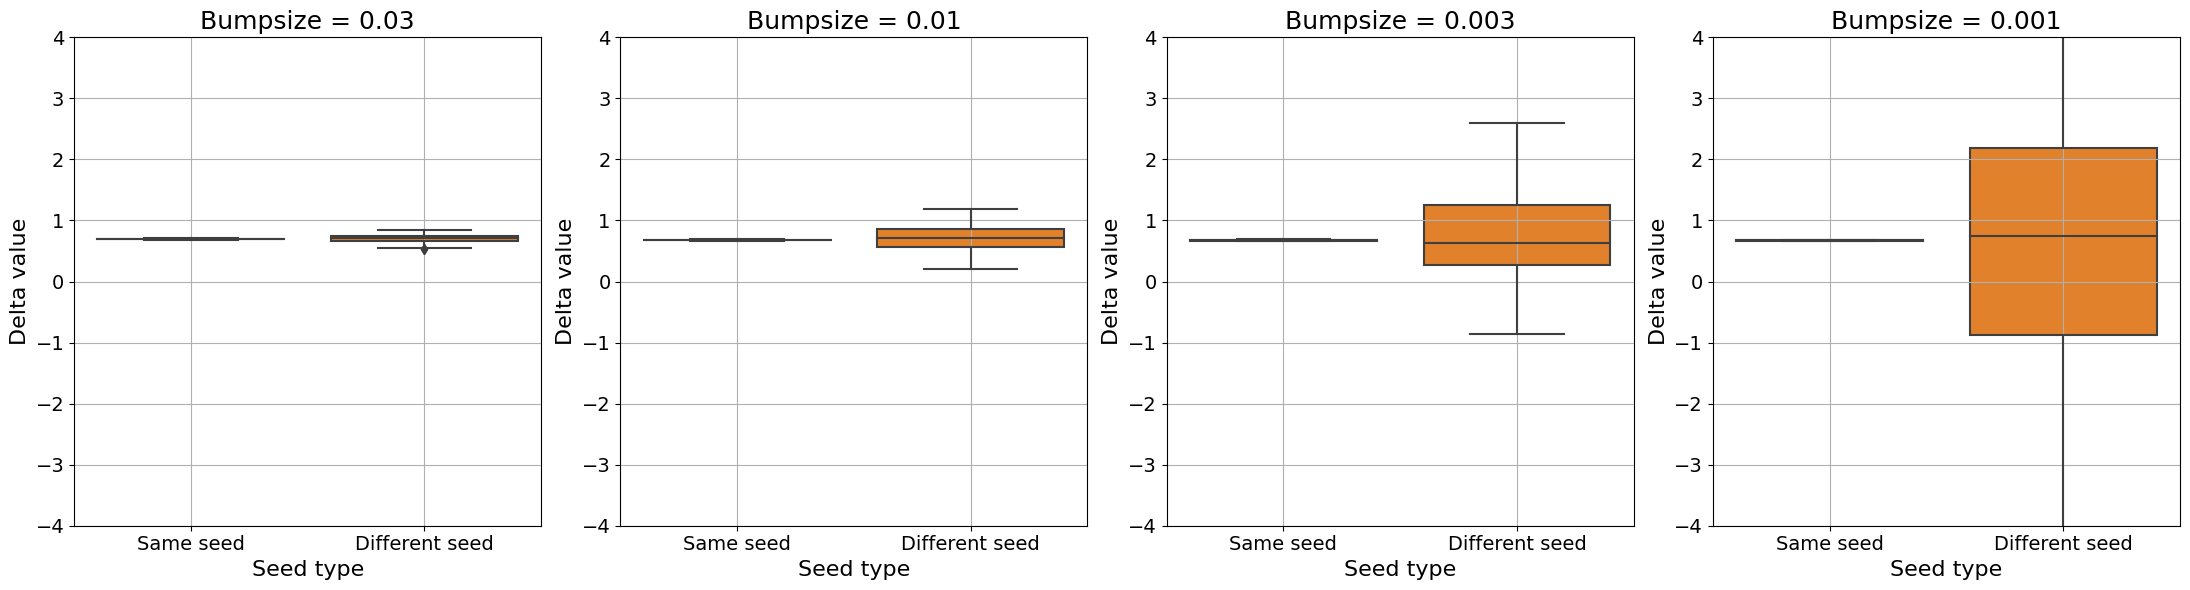

In [ ]:
bumpsizes = [0.03, 0.01, 0.003, 0.001]
S0 = 100 
T = 1.0 
N = 200 
K = 99 
r = 0.06 
sigma = 0.2 
seeds = np.arange(101)
seed_results = []

# Visualization
fig, axs = plt.subplots(1, 4, figsize=(22, 6))
axs = axs.flatten()  

for index, bumpsize in enumerate(bumpsizes):
    deltas_same_seed = []
    deltas_diff_seed = []
    for seed in seeds:
        # Calculate Delta with the bump-and-revalue method
        delta_same_seed, delta_diff_seed = bump_and_revalue(S0, K, T, r, sigma, N, seed, bumpsize)
        deltas_same_seed.append(delta_same_seed)
        deltas_diff_seed.append(delta_diff_seed)  
    # Box-plot
    var_same = format(np.var(deltas_same_seed), ".1e")
    var_diff = format(np.var(deltas_diff_seed), ".1e")
    #data = {f'Same seed(mean={round(np.mean(deltas_same_seed),3)},var={var_same})': deltas_same_seed, 
    #       f'Different seed(mean={round(np.mean(deltas_diff_seed),3)},var={var_diff})': deltas_diff_seed}
    data = {f'Same seed': deltas_same_seed, 
            f'Different seed': deltas_diff_seed}
    data_long_format = pd.DataFrame(list(data.items()), columns=['Seed type', 'Delta value']).explode('Delta value')
    data_long_format['Delta value'] = data_long_format['Delta value'].astype(float)
    seed_same_result = {"Seed Type": "Same Seed",
                        "Bump Size": bumpsize,
                        "Mean": round(np.mean(deltas_same_seed),3),
                        "Var": format(np.var(deltas_same_seed), ".1e")}
    seed_results.append(seed_same_result)
    seed_diff_result = {"Seed Type": "Different Seed",
                        "Bump Size": bumpsize,
                        "Mean": round(np.mean(deltas_diff_seed),3),
                        "Var": format(np.var(deltas_diff_seed), ".1e")}
    seed_results.append(seed_diff_result)
    sns.boxplot(x='Seed type', y='Delta value', data=data_long_format, ax=axs[index])
    axs[index].set_title(f'Bumpsize = {bumpsize}', fontsize = 18)
    axs[index].set_xlabel('Seed type', fontsize = 16)
    axs[index].set_ylim([-4, 4])
    axs[index].set_ylabel('Delta value', fontsize = 16)
    axs[index].tick_params(axis='both', labelsize=14) 
    axs[index].grid(True)

plt.tight_layout()
plt.savefig('Figures/4.2.1 comparison_of_seeds_bumpsizes.png', dpi=500)
plt.show()


        Seed Type  Bump Size   Mean      Var
0       Same Seed     0.0300 0.6990  3.3e-05
1  Different Seed     0.0300 0.7080  4.3e-03
2       Same Seed     0.0100 0.6820  3.4e-05
3  Different Seed     0.0100 0.7040  4.9e-02
4       Same Seed     0.0030 0.6760  3.4e-05
5  Different Seed     0.0030 0.7060  5.4e-01
6       Same Seed     0.0010 0.6740  3.5e-05
7  Different Seed     0.0010 0.6000  5.4e+00


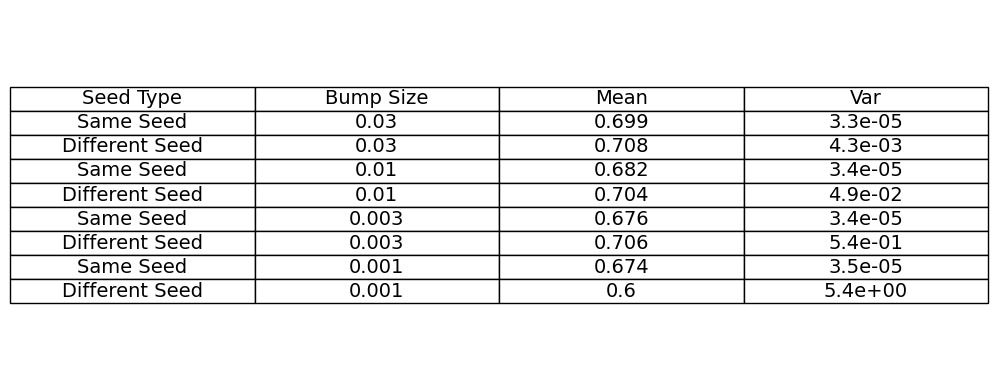

In [ ]:
# Convert data to DataFrame
df = pd.DataFrame(seed_results)

pd.set_option('display.float_format', '{:.4f}'.format) 

print(df)

# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(10, 4))  # Adjust the size as needed

# Remove axes
ax.axis('off')
ax.axis('tight')

# Create a table and populate it with the DataFrame content
tab = ax.table(cellText=df.values, colLabels=df.columns, cellLoc = 'center', loc='center')

# Adjust table scale
tab.auto_set_font_size(False)
tab.set_fontsize(14)
tab.scale(1.2, 1.2)

# Save the figure containing the table as a PNG file
plt.tight_layout()
plt.savefig('Figures/4.2.1 table compare_of_seeds_bumpsizes.png', dpi=500, bbox_inches='tight')
plt.show()

### Q2: Use multiple methods to compute delta for a digital option 

#### Use BS model to calculate  digital option

In the Black-Scholes model, the value of a digital call option (assuming a payout of 1 euro) can be represented as follows:

\begin{aligned}
V &= e^{-rT}N(d_2), \\
\text{where} \\
d_2 &= \frac{\ln(S_0 / K) + (r - \sigma^2 / 2)T}{\sigma\sqrt{T}},
\end{aligned}

`N()` denotes the cumulative distribution function of the standard normal distribution.

The Delta of the digital call option can be derived from the derivative of the option's value with respect to the stock price `S_0`:

\begin{aligned}
\Delta &= \frac{\partial V}{\partial S_0} = \frac{\partial}{\partial S_0} \left( e^{-rT}N(d_2) \right)
\end{aligned}

Since `N(d_2)` is derived from `d_2`, which in turn depends on `S_0`, the calculation involves taking the derivative of `d_2` with respect to `S_0`, followed by applying the chain rule to obtain the Delta of the digital call option.
The derivative of `d_2` with respect to the initial stock price `S_0` is:

\begin{aligned}
\frac{\partial d_2}{\partial S_0} &= \frac{1}{S_0 \sigma \sqrt{T}}
\end{aligned}

The probability density function `n(d_2)` at `d_2 `is:

\begin{aligned}
n(d_2) &= \frac{1}{\sqrt{2\pi}} \exp \left( -\frac{d_2^2}{2} \right)
\end{aligned}

Substituting the derivative of \(d_2\) with respect to \(S_0\) into the Delta formula, we get:

\begin{aligned}
\Delta &= e^{-rT} \frac{1}{\sqrt{2\pi}} \exp \left( -\frac{d_2^2}{
2} \right) \frac{1}{S_0 \sigma \sqrt{T}}
\end{aligned}


In [ ]:
S0 = 100  
K = 100   
T = 1.0  
r = 0.06  
sigma = 0.2  

# Calculate d2
d2 = (np.log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

# Calculate n(d2)
n_d2 = 1 / np.sqrt(2 * np.pi) * np.exp(-d2**2 / 2)

delta = np.exp(-r * T) * n_d2 / (S0 * sigma * np.sqrt(T))

print(f"Exact numerical solution of delta calculated using BS model = {delta}")

Exact numerical solution of delta calculated using BS model = 0.01841350701516617


#### Bump-and-revalue method

In [ ]:
# Bump-and-revalue method to estimate Delta
def bump_and_revalue(S0, K, T, r, sigma, N, seed=np.random.seed(), bump_size=0.01):
    # Monte Carlo simulation to estimate the option price for original and bumped S0
    def simulate_option_price(S0, r, sigma, T, N, n_simulations=10000):
        dt = T / N
        prices = np.zeros(n_simulations)
        for i in range(n_simulations):
            dW = np.random.normal(scale=np.sqrt(dt), size=N)
            path = S0 * np.cumprod(np.exp((r - 0.5 * sigma ** 2) * dt + sigma * dW))
            payoff = max(path[-1] - K, 0)
            prices[i] = 1 if payoff > 0 else 0
        option_price = np.exp(-r * T) * np.mean(prices)
        return option_price

    # Calculate the option price for unbumped S0
    np.random.seed(seed)
    price_unbumped = simulate_option_price(S0, r, sigma, T, N)

    # Bump the underlying asset price
    S0_bumped = S0 + S0 * bump_size
    
    np.random.seed(seed)  # Use the same seed for reproducibility
    price_bumped_same_seed = simulate_option_price(S0_bumped, r, sigma, T, N)

    np.random.seed()  # Use a different seed
    price_bumped_diff_seed = simulate_option_price(S0_bumped, r, sigma, T, N)

    delta_same_seed = (price_bumped_same_seed - price_unbumped) / (S0 * bump_size)

    delta_diff_seed = (price_bumped_diff_seed - price_unbumped) / (S0 * bump_size)

    return delta_same_seed, delta_diff_seed

In [ ]:
S0 = 100
T = 1.0 
N = 200 
K = 100
r = 0.06 
sigma = 0.2 
seeds = np.arange(101)

deltas_same_seed = []
deltas_diff_seed = []

for seed in seeds:
    # Calculate Delta with the bump-and-revalue method
    delta_same_seed, delta_diff_seed = bump_and_revalue(S0, K, T, r, sigma, N, seed, bump_size=0.01)
    deltas_same_seed.append(delta_same_seed)
    deltas_diff_seed.append(delta_diff_seed)    

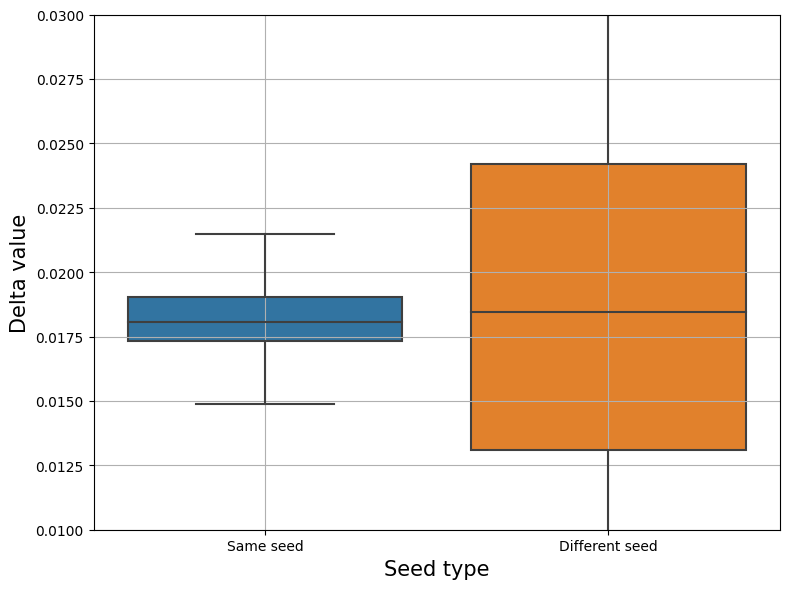

Result under 100 simulation round
For Same seed : mean = 0.01819, variance = 2.0e-06
For Different seed : mean = 0.0184, variance = 5.0e-05


In [ ]:
# Data adjust
var_same = format(np.var(deltas_same_seed), ".1e")
var_diff = format(np.var(deltas_diff_seed), ".1e")
# Box-plot
data = {f'Same seed': deltas_same_seed, 
        f'Different seed': deltas_diff_seed}
data_long_format = pd.DataFrame(list(data.items()), columns=['Seed type', 'Delta value']).explode('Delta value')
data_long_format['Delta value'] = data_long_format['Delta value'].astype(float)

plt.figure(figsize=(8, 6))
sns.boxplot(x='Seed type', y='Delta value', data=data_long_format)
plt.xlabel('Seed type', fontsize = 15)
plt.ylim([0.01, 0.03])
plt.ylabel('Delta value', fontsize = 15)
plt.grid(True)

plt.tight_layout()
plt.savefig('Figures/4.2.2 bump.png', dpi=500, bbox_inches='tight')
plt.show()

print("Result under 100 simulation round")
print(f"For Same seed : mean = {round(np.mean(deltas_same_seed),5)}, variance = {var_same}")
print(f"For Different seed : mean = {round(np.mean(deltas_diff_seed),5)}, variance = {var_diff}")

#### Pathwise method

$H(S_T) = 
\begin{cases}
1 & \text{if } S_T > K, \\
0 & \text{if } S_T \leq K.
\end{cases}$


A smoothed approximation to the digital option payoff can
be:

$H_\epsilon(S_T) = \frac{1}{1 + \exp\left(-\frac{S_T - K}{\epsilon}\right)}$

Compute partial derivatives of smoothed payoff functions:

$\frac{\partial H_\epsilon(S_T)}{\partial S_T} = \frac{\exp\left(-\frac{S_T - K}{\epsilon}\right)}{\epsilon \left(1 + \exp\left(-\frac{S_T - K}{\epsilon}\right)\right)^2}$


In [ ]:

S0 = 100    
K = 100     
T = 1.0     
r = 0.06    
sigma = 0.2 
M = 10000   
epsilons = [0.1, 0.3, 1]  # smooth approximation parameter

# Partial derivatives of smoothed payoff functions
def logistic_derivative(ST, K, epsilon):
    e_term = np.exp(-(ST - K) / epsilon)
    return e_term / (epsilon * (1 + e_term)**2)

delta_estimates_dif_epsilon = []
simulation_round = 100 # Simulation rounds
for epsilon in epsilons:
    delta_estimates = []
    for _ in range(simulation_round):
        np.random.seed()
        Z = np.random.normal(0, 1, M)
        ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)

        logistic_derivatives = logistic_derivative(ST, K, epsilon)

        adjusted_derivatives = logistic_derivatives * ST / S0

        delta_estimate = np.exp(-r * T) * np.mean(adjusted_derivatives)
        delta_estimates.append(delta_estimate)
    delta_estimates_dif_epsilon.append(delta_estimates)


/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_58694/3120213862.py:12: RuntimeWarning: overflow encountered in square
  return e_term / (epsilon * (1 + e_term)**2)


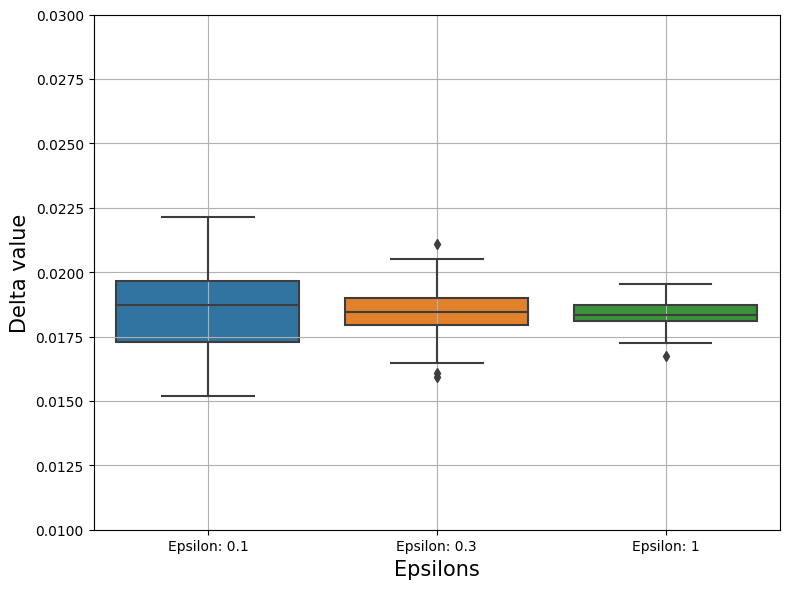

Result under 100 simulation round
For Epsilon = 0.1 : mean = 0.01859, variance = 2.7e-06
For Epsilon = 0.3 : mean = 0.01841, variance = 8.9e-07
For Epsilon = 1 : mean = 0.01838, variance = 2.6e-07


In [ ]:
# Data adjust
means = []
vars = []
for i in range(len(delta_estimates_dif_epsilon)):
    vars.append(format(np.var(delta_estimates_dif_epsilon[i]), ".1e"))
    means.append(round(np.mean(delta_estimates_dif_epsilon[i]), 5))

# Draw box-plot
data = {}
for i in range(len(delta_estimates_dif_epsilon)):
    key = f'Epsilon: {epsilons[i]}'
    data[key] = delta_estimates_dif_epsilon[i]

data_long_format = pd.DataFrame(list(data.items()), columns=['Epsilons', 'Delta value']).explode('Delta value')
data_long_format['Delta value'] = data_long_format['Delta value'].astype(float)

plt.figure(figsize=(8, 6))
sns.boxplot(x='Epsilons', y='Delta value', data=data_long_format)
plt.xlabel('Epsilons', fontsize = 15)
plt.ylabel('Delta value', fontsize = 15)
plt.ylim([0.01, 0.03])
plt.grid(True)

plt.tight_layout()
plt.savefig('Figures/4.2.2 pathwise.png', dpi=500, bbox_inches='tight')
plt.show()

print("Result under 100 simulation round")
for i in range(len(delta_estimates_dif_epsilon)):
    print(f"For Epsilon = {epsilons[i]} : mean = {means[i]}, variance = {vars[i]}")

#### Likelihood Ratio Method

We estimate the derivative using following method:


$\begin{aligned}
\frac{\partial\pi_0(p)}{\partial p}& =\int_0^\infty H(x)\frac{\partial g(x,p)}{\partial p}dx  \\
&=\int_0^\infty H(x)\frac{\partial\log(g(x,p))}{\partial p}g(x,p)dx \\
&=\mathbb{E}_{\mathbb{Q}}\left[H(S_T)\frac{\partial\log(g(S_T,p))}{\partial p}\right]
\end{aligned}$

In this particular question, we have:

$\hat{\Delta}=e^{-rT}\frac1M\sum_{i=1}^M\left(1_{\{S_{T,i}>K\}}\frac{Z_i}{S_0\sigma\sqrt{T}}\right)$

In [ ]:
S0 = 100    
K = 100     
T = 1.0     
r = 0.06    
sigma = 0.2 
M = 10000   
simulation_round = 100

LRM_deltas = []
for _ in range(simulation_round):
    np.random.seed()
    Z = np.random.normal(0, 1, M)
    ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
    # 1_{ST>K} is an indicator function. When ST>K, it takes 1, otherwise it takes 0.
    indicator = (ST > K).astype(int)
    LRM_delta = np.exp(-r * T) * np.mean(indicator * Z / (S0 * sigma * np.sqrt(T)))
    LRM_deltas.append(LRM_delta)

print(np.mean(LRM_deltas))
print(np.var(LRM_deltas))

0.018481656023269587
6.770651398504629e-08


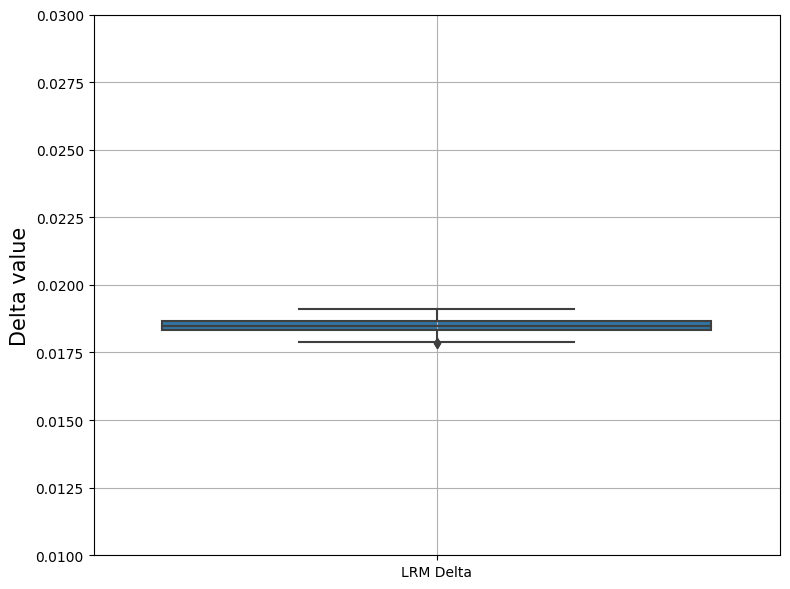

Result under 100 simulation round
For LRM method : mean = 0.01848, variance = 6.8e-08


In [ ]:
# Data adjust
var=format(np.var(LRM_deltas), ".1e")
mean=round(np.mean(LRM_deltas), 5)

data = {f'LRM Delta': LRM_deltas,}
data_long_format = pd.DataFrame(list(data.items()), columns=['LRM method', 'Delta value']).explode('Delta value')
data_long_format['Delta value'] = data_long_format['Delta value'].astype(float)

plt.figure(figsize=(8, 6))
sns.boxplot(x='LRM method', y='Delta value', data=data_long_format)
#plt.title('Result of LRM method', fontsize = 16)
plt.xlabel('')
plt.ylabel('Delta value', fontsize = 15)
plt.ylim([0.01, 0.03])
plt.grid(True)

plt.tight_layout()
plt.savefig('Figures/4.2.2 Likelihood.png', dpi=500, bbox_inches='tight')

plt.show()

print("Result under 100 simulation round")
print(f"For LRM method : mean = {mean}, variance = {var}")

#### Result comparison

Box-plot

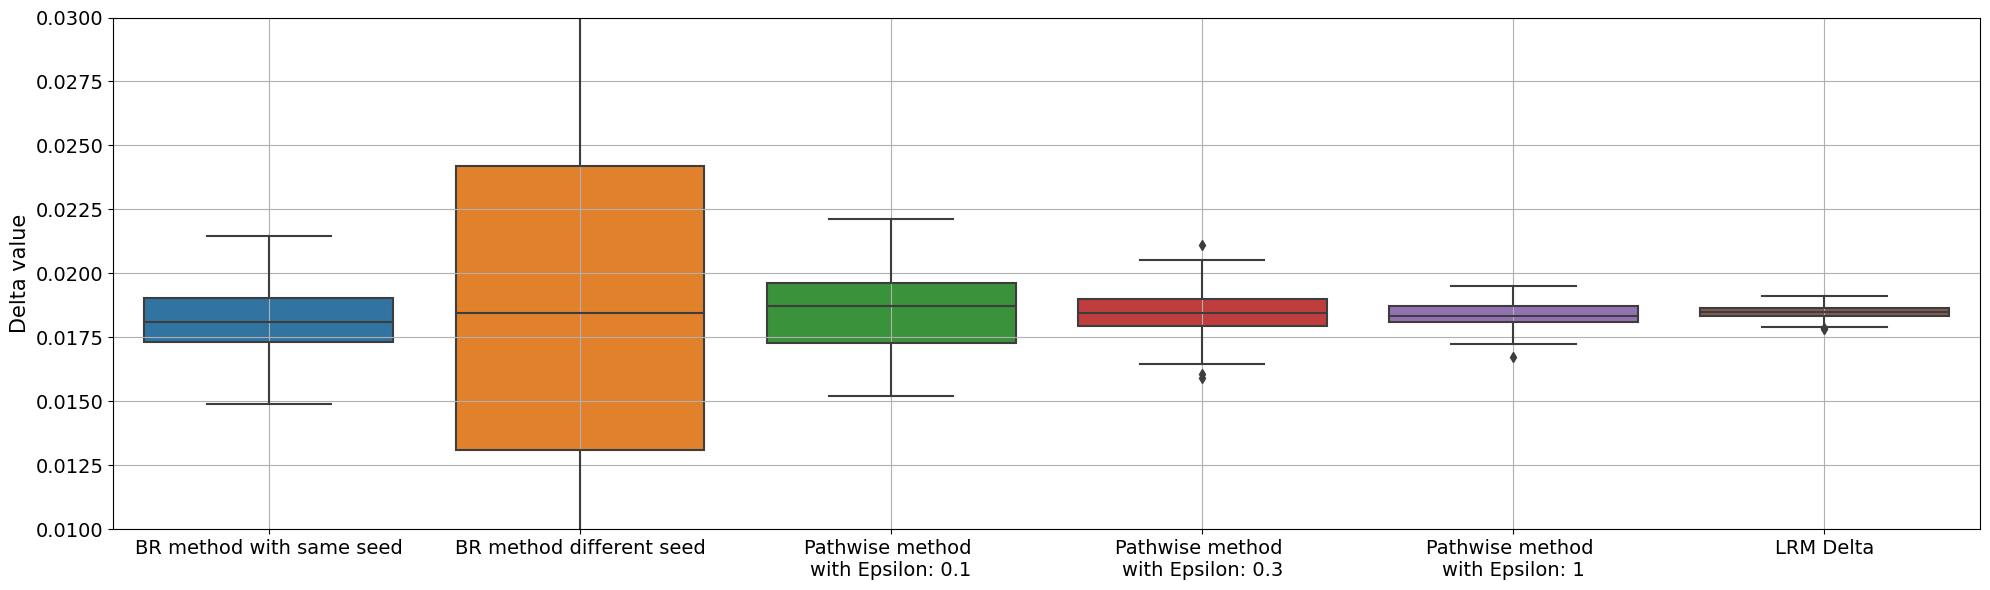

In [ ]:
Box_plot_data = {f'BR method with same seed': deltas_same_seed, 
                 f'BR method different seed': deltas_diff_seed}
for i in range(len(delta_estimates_dif_epsilon)):
    key = f'Pathwise method \nwith Epsilon: {epsilons[i]}'
    Box_plot_data[key] = delta_estimates_dif_epsilon[i]

Box_plot_data[f'LRM Delta'] = LRM_deltas
data_long_format = pd.DataFrame(list(Box_plot_data.items()), columns=['LRM method', 'Delta value']).explode('Delta value')
data_long_format['Delta value'] = data_long_format['Delta value'].astype(float)

plt.figure(figsize=(20, 6))
sns.boxplot(x='LRM method', y='Delta value', data=data_long_format)
#plt.title('Result of LRM method', fontsize = 16)
plt.xlabel('')
plt.ylabel('Delta value', fontsize = 15)
plt.ylim(0.01,0.03)
plt.grid(True)
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.tight_layout()
plt.savefig('Figures/4.2.2 6 box plot.png', dpi=500, bbox_inches='tight')

plt.show()

Table

In [ ]:
datas = []
data_bump_same = {"test type":"Bump-and-revalue method \nwith same seed",
                  "mean": round(np.mean(deltas_same_seed),5),
                  "var":var_same}
data_bump_diff = {"test type":"Bump-and-revalue method \nwith different seed",
                  "mean": round(np.mean(deltas_diff_seed),5),
                  "var":var_diff}
datas.append(data_bump_same)
datas.append(data_bump_diff)
for i in range(3):
    data_pathwise = {"test type":f"Pathwise method with \nepsilon = {epsilons[i]}",
                  "mean": means[i],
                  "var":vars[i]}
    datas.append(data_pathwise)

data_LRM = {"test type":"LRM method",
            "mean": mean,
            "var":var}
datas.append(data_LRM)

# Convert data to DataFrame
df = pd.DataFrame(datas)

pd.set_option('display.float_format', '{:.4f}'.format) 

print(df)

                                       test type   mean      var
0       Bump-and-revalue method \nwith same seed 0.0182  2.0e-06
1  Bump-and-revalue method \nwith different seed 0.0184  5.0e-05
2           Pathwise method with \nepsilon = 0.1 0.0186  2.7e-06
3           Pathwise method with \nepsilon = 0.3 0.0184  8.9e-07
4             Pathwise method with \nepsilon = 1 0.0184  2.6e-07
5                                     LRM method 0.0185  6.8e-08


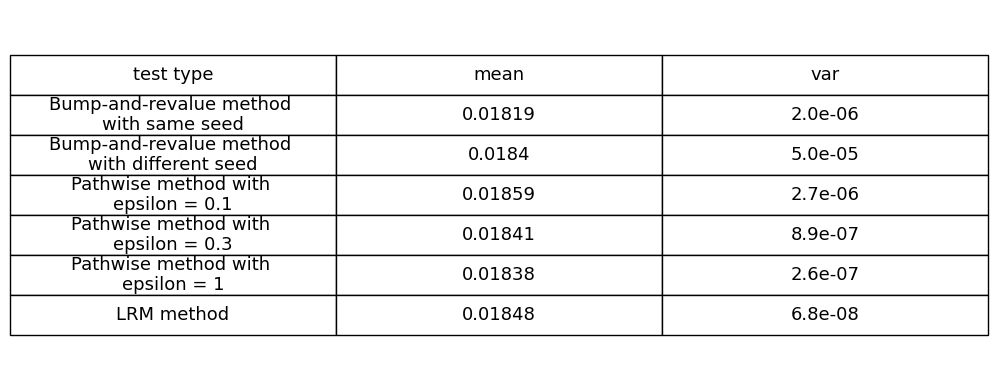

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.axis('off')
ax.axis('tight')

# Create a table and populate it with the DataFrame content
tab = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

tab.auto_set_font_size(False)
tab.set_fontsize(13)
tab.scale(1.2, 2)

# Save the figure containing the table as a PNG file
plt.tight_layout()
plt.savefig('Figures/4.2.2_table_compare.png', dpi=500, bbox_inches='tight')
plt.show()

Exact numerical solution of delta calculated using BS model = 0.01841350701516617

#### Compare different methods for convergence and convergence speed
Convergence:
If the 95% confidence interval of a method's estimated value can continuously (rather than accidentally) contain the true value after the number of simulations reaches a certain level, and the width of this interval shrinks as the number of simulations increases, then the method can be considered convergent.

Convergence speed:
Perform 30 simulations of each method, and then record the number of simulations in each simulation where the 95% confidence interval first contains the true value (and continues to include it thereafter) to compare the convergence speed of different methods.

In [ ]:
def LRM_simulation(S0, K, T, sigma, M, simulation_round):
    LRM_deltas = np.zeros(simulation_round)
    for i in range(simulation_round):
        np.random.seed()
        Z = np.random.normal(0, 1, M)
        ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
        indicator = (ST > K).astype(int)
        LRM_deltas[i] = np.exp(-r * T) * np.mean(indicator * Z / (S0 * sigma * np.sqrt(T)))
    return LRM_deltas

# Monte Carlo simulation to estimate the option price for original and bumped S0
def simulate_option_price(S0, r, sigma, T, N, n_simulations=1):
    dt = T / N
    prices = np.zeros(n_simulations)
    for i in range(n_simulations):
        np.random.seed()
        Z = np.random.normal(0, 1, M)
        ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
        payoff = max(ST - K, 0)
        prices[i] = 1 if payoff > 0 else 0
    option_price = np.exp(-r * T) * np.mean(prices)
    return option_price
    
def bump_and_revalue(S0, K, T, sigma, M, simulation_round, seed=np.random.seed(), bump_size=0.01):
    BR_same_deltas = np.zeros(simulation_round)
    BR_diff_deltas = np.zeros(simulation_round)
    for i in range(simulation_round):
    
        np.random.seed(seed)
        price_unbumped = simulate_option_price(S0, r, sigma, T, N)

        # Bump the underlying asset price
        S0_bumped = S0 + S0 * bump_size

        np.random.seed(seed)  
        price_bumped_same_seed = simulate_option_price(S0_bumped, r, sigma, T, N)
        np.random.seed()  
        price_bumped_diff_seed = simulate_option_price(S0_bumped, r, sigma, T, N)

        delta_same_seed = (price_bumped_same_seed - price_unbumped) / (S0 * bump_size)
        delta_diff_seed = (price_bumped_diff_seed - price_unbumped) / (S0 * bump_size)
        BR_same_deltas[i] = delta_same_seed
        BR_diff_deltas[i] = delta_diff_seed
    return BR_same_deltas, BR_diff_deltas

def pathwise_method(S0, K, T, sigma, M, simulation_round):
    Pathwise_deltas = []
    epsilon = 0.1
    for _ in range(simulation_round):
        np.random.seed()
        Z = np.random.normal(0, 1, M)
        ST = S0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z)
        logistic_derivatives = logistic_derivative(ST, K, epsilon)

        adjusted_derivatives = logistic_derivatives * ST / S0

        delta_estimate = np.exp(-r * T) * np.mean(adjusted_derivatives)
        Pathwise_deltas.append(delta_estimate)
    return Pathwise_deltas

In [ ]:
S0 = 100      
K = 100       
T = 1.0    
r = 0.06      
sigma = 0.2   
M = 1     
simulation_round = 10000 # Number of simulation rounds
true_delta = 0.01841    # True delta value from BS model

LRM_deltas = LRM_simulation(S0, K, T, sigma, M, simulation_round)
BR_same_deltas, BR_diff_deltas = bump_and_revalue(S0, K, T, sigma, M, simulation_round, seed=np.random.seed(), bump_size=0.01)
Pathwise_deltas = pathwise_method(S0, K, T, sigma, M, simulation_round)
delta_results = {
                  "Bump method(same seed)" :BR_same_deltas,
                  "Bump method(different seed)" : BR_diff_deltas,
                  "Pathwise method": Pathwise_deltas,
                  "LRM method" :LRM_deltas,
                  }

/var/folders/st/hfszkgw55n73h3v2jz7n8xth0000gn/T/ipykernel_58694/2629278496.py:13: RuntimeWarning: overflow encountered in square
  return e_term / (epsilon * (1 + e_term)**2)


Visualization

In [ ]:
# Function to calculate the confidence interval for delta estimates up to each simulation round
def calculate_confidence_intervals(deltas, confidence_level=0.95):
    intervals = []
    for round_number in range(1, len(deltas) + 1):
        sample_mean = np.mean(deltas[:round_number])
        sample_std = np.std(deltas[:round_number], ddof=1)
        margin_of_error = stats.norm.ppf((1 + confidence_level) / 2) * (sample_std / np.sqrt(round_number))
        intervals.append((sample_mean - margin_of_error, sample_mean + margin_of_error))
    return intervals
# Function to calculate the confidence intervals for delta estimates at each increment of 100 simulations
def calculate_confidence_intervals_incremental(deltas, increments=100, confidence_level=0.95):
    interval_means = []
    lower_bounds = []
    upper_bounds = []
    for round_number in range(increments, len(deltas) + 1, increments):
        sample_mean = np.mean(deltas[:round_number])
        sample_std = np.std(deltas[:round_number], ddof=1)
        margin_of_error = stats.norm.ppf((1 + confidence_level) / 2) * (sample_std / np.sqrt(round_number))
        
        interval_means.append(sample_mean)
        lower_bounds.append(sample_mean - margin_of_error)
        upper_bounds.append(sample_mean + margin_of_error)

    return interval_means, lower_bounds, upper_bounds

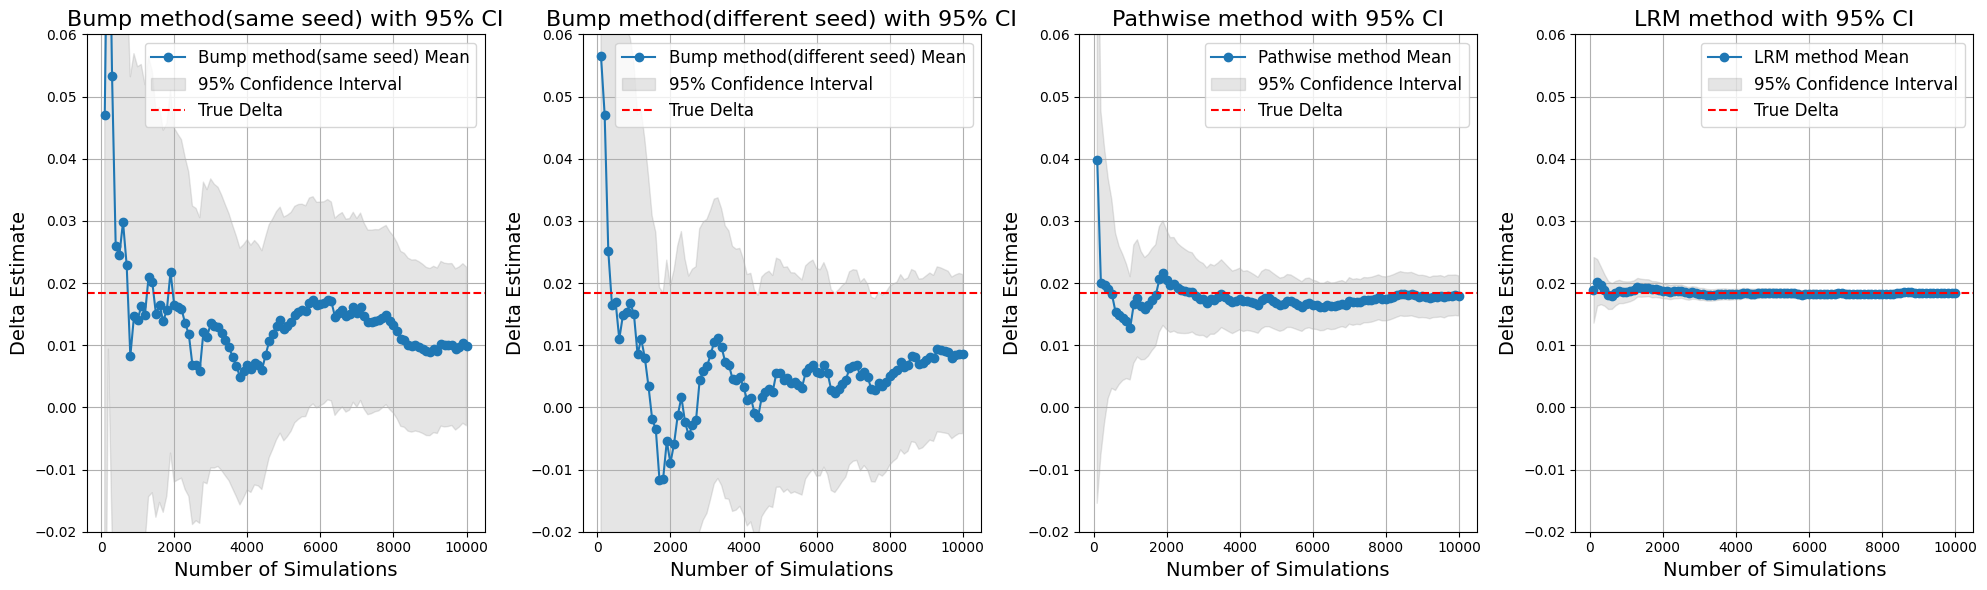

In [ ]:
plt.figure(figsize=(20, 6))
for i, (key, value) in enumerate(delta_results.items(), start=1):
    means, lower_bounds, upper_bounds = calculate_confidence_intervals_incremental(value, increments=100)

    x_values = list(range(100, simulation_round + 1, 100))

    plt.subplot(1, 4, i)  
    plt.plot(x_values, means, label=f'{key} Mean', marker='o')
    plt.fill_between(x_values, lower_bounds, upper_bounds, color='gray', alpha=0.2, label='95% Confidence Interval')
    plt.axhline(y=true_delta, color='r', linestyle='--', label='True Delta')
    plt.xlabel('Number of Simulations', fontsize = 14)
    plt.ylabel('Delta Estimate', fontsize = 14)
    plt.ylim(-0.02,0.06)
    plt.title(f'{key} with 95% CI', fontsize = 16)
    plt.legend(fontsize = 12)
    plt.grid(True)

plt.tight_layout()
plt.savefig('Figures/4.2.2 convergency.png', dpi=500, bbox_inches='tight')
plt.show()

## Part III Variance Reduction

### Q1: Compare the price of Asian call option based on geometric averages between the analytical expression and Monte-Carlo simulations

In [ ]:
S0 = 100 
K = 100   
T = 1      
r = 0.05     
sigma = 0.2
N = 10000   

def geometric_asian_call_price(S0, K, T, r, sigma, N):
    sigma_hat = sigma * np.sqrt((2 * N + 1) / (6 * (N + 1)))
    r_hat = (r - 0.5 * sigma**2 + sigma_hat**2) / 2
    d1 = (np.log(S0 / K) + (r_hat + 0.5 * sigma_hat**2) * T) / (sigma_hat * np.sqrt(T))
    d2 = d1 - sigma_hat * np.sqrt(T)
    geometric_asian_call_theoretical = S0 * np.exp((r_hat - r) * T) * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return geometric_asian_call_theoretical

geometric_asian_call_theoretical = geometric_asian_call_price(S0, K, T, r, sigma, N)
print(geometric_asian_call_theoretical)


5.546690676233013


In [ ]:
def simulate_gbm(S0, r, sigma, T, n_steps):
    dt = T/n_steps  
    dW = np.random.normal(scale=np.sqrt(dt), size=n_steps)
    log_S = np.log(S0) + np.cumsum((r - 0.5 * sigma**2) * dt + sigma * dW)
    S = np.exp(log_S)  
    return S

def asian_call_payoff(S_path, K, r, T):
    geometric_mean = np.exp(np.mean(np.log(S_path)))  
    payoff = np.maximum(geometric_mean - K, 0)        
    discounted_payoff = np.exp(-r * T) * payoff     
    return discounted_payoff

In [ ]:
S0 = 100       
K = 100        
T = 1          
r = 0.05       
sigma = 0.2
N = 10000      
n_simulations = 10000  

payoffs = np.zeros(n_simulations)

for i in range(n_simulations):
    S_path = simulate_gbm(S0, r, sigma, T, N)
    payoffs[i] = asian_call_payoff(S_path, K, r, T)
Asian_call_Monte_Carlo = np.mean(payoffs)
geometric_asian_call_theoretical = geometric_asian_call_price(S0, K, T, r, sigma, N)

print(f"Asian_call_Monte_Carlo = {Asian_call_Monte_Carlo}, Simulation time = {n_simulations}")
print(f"Asian_call_Analytical_result = {geometric_asian_call_theoretical}")
print(f"Relative error = {abs(Asian_call_Monte_Carlo - geometric_asian_call_theoretical)/geometric_asian_call_theoretical}")

Asian_call_Monte_Carlo = 5.518583635473161, Simulation time = 10000
Asian_call_Analytical_result = 5.546690676233013
Relative error = 0.005067353202205333


In [ ]:
S0 = 100
K = 100
T = 1
r = 0.05
sigma = 0.2
N = 10000
n_simulations = 1000
n_batches = 100  # Number of batches to simulate

# Run Monte Carlo simulations in batches
batch_results = np.zeros(n_batches)
theoretical_price = geometric_asian_call_price(S0, K, T, r, sigma, N)

for batch in range(n_batches):
    np.random.seed()  # Ensure randomness for each batch
    payoffs = np.zeros(n_simulations)
    for i in range(n_simulations):
        S_path = simulate_gbm(S0, r, sigma, T, N)
        payoffs[i] = asian_call_payoff(S_path, K, r, T)
    batch_results[batch] = np.mean(payoffs)

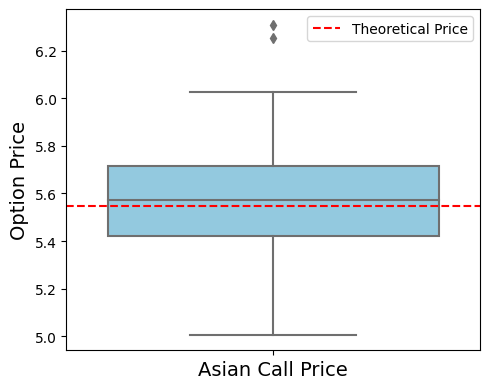

In [ ]:
# Draw box-plot
plt.figure(figsize=(5, 4))
sns.boxplot(data=batch_results, color="skyblue")
plt.axhline(y=theoretical_price, color='r', linestyle='--', label='Theoretical Price')
plt.ylabel('Option Price',fontsize = 14)
plt.xticks([0], ['Asian Call Price'],fontsize = 14)
plt.legend()
plt.tight_layout()
plt.savefig('Figures/4.3.1 boxplot.png', dpi=500, bbox_inches='tight')
plt.show()


### Q2 : Explain how the strategy of using this as a control variate works.

Control Variates Method

The **Control Variates Method** is a method used to reduce variance in Monte Carlo simulations. The core idea of this method is to use a control variable with a known expected value to reduce the variance of the simulation output. Here we use the value of an Asian option based on geometric averages as a control variable to reduce variance.

Specific Implementation Steps:

1. **Identify a Control Variate**: Select the geometric average Asian option as the control variate for the arithmetic average Asian option.

2. **Compute the Expected Value of the Control Variate**:  Calculate the expected value of the geometric average Asian option.

3. **Simulate Both Payoffs**: During the simulation, compute both the payoff of the option of interest (arithmetic average Asian option) and the payoff of the control variate (geometric average Asian option).

4. **Calculate the Covariance and Variance**: Estimate the covariance between the payoff and the control variate, and the variance of the control variate, from the simulated data.

5. **Adjust the Payoff**: Use the covariance and the known expected value of the control variate to adjust the payoff of the option of interest. The adjustment is typically made by constructing a linear combination of the payoff and the control variate. The coefficients of this linear combination are chosen to minimize the variance of the estimator.

6. **Estimate the Option Price**: Estimate the Option Price: Calculate the price of the option of interest using the adjusted payoffs.


### Q3：Apply the control variates technique

In [ ]:
def asian_call_payoff_modified(S_path, K, r, T):
    arithmetic_mean = np.mean(S_path)
    geometric_mean = np.exp(np.mean(np.log(S_path)))
    payoff_arithmetic = np.maximum(arithmetic_mean - K, 0)
    payoff_geometric = np.maximum(geometric_mean - K, 0)
    discounted_payoff_arithmetic = np.exp(-r * T) * payoff_arithmetic
    discounted_payoff_geometric = np.exp(-r * T) * payoff_geometric
    return discounted_payoff_arithmetic, discounted_payoff_geometric

def control_variates_simulation(S0, K, T, r, sigma, N, n_simulations):
    payoffs_arithmetic = np.zeros(n_simulations)
    payoffs_geometric = np.zeros(n_simulations)
    geometric_asian_call_theoretical = geometric_asian_call_price(S0, K, T, r, sigma, N)
    for i in range(n_simulations):
        S_path = simulate_gbm(S0, r, sigma, T, N)
        payoff_arithmetic, payoff_geometric = asian_call_payoff_modified(S_path, K, r, T)
        payoffs_arithmetic[i] = payoff_arithmetic
        payoffs_geometric[i] = payoff_geometric

    # Calculate the adjustment amount of the control variable
    cov_matrix = np.cov(payoffs_arithmetic, payoffs_geometric)
    cov_XY = cov_matrix[0, 1]
    var_Y = cov_matrix[1, 1]
    if var_Y == 0:
        c = 0
    else:
        c = cov_XY / var_Y

    # Adjusting the simulated value of the arithmetic mean Asian call option using control variables
    adjusted_payoffs = payoffs_arithmetic - c * (payoffs_geometric - geometric_asian_call_theoretical)
    adjusted_price_estimate = np.mean(adjusted_payoffs)

    return np.mean(payoffs_arithmetic), adjusted_price_estimate

S0 = 100       
K = 100        
T = 1          
r = 0.05       
sigma = 0.2    
N = 10000      
n_simulations = 1000 

Basic_estimate, adjusted_estimate =  control_variates_simulation(S0, K, T, r, sigma, N, n_simulations)
print("Basic Arithmetic Mean Price Estimate:", Basic_estimate)
print("Adjusted Arithmetic Mean Price Estimate:", adjusted_estimate)

Basic Arithmetic Mean Price Estimate: 6.301105125209835
Adjusted Arithmetic Mean Price Estimate: 5.760280701959568


In [ ]:
results_arithmetic = []
results_adjusted = []
simulation_time_cv = 100
for _ in range(simulation_time_cv):
    mean_arithmetic, adjusted_estimate = control_variates_simulation(S0, K, T, r, sigma, N, n_simulations)
    results_arithmetic.append(mean_arithmetic)
    results_adjusted.append(adjusted_estimate)

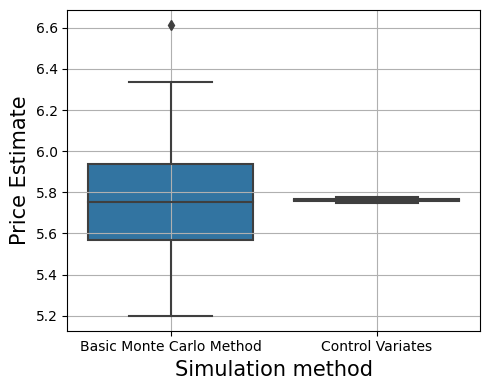

Result under 100 simulation round
For Basic Monte Carlo Method : mean = 5.748258615647184, variance = 0.07486315487169415
For Control Variates Method : mean = 5.763197702368388, variance = 4.4621996119347406e-05


In [ ]:
# Box-plot
data = {'Basic Monte Carlo Method': results_arithmetic, 'Control Variates': results_adjusted}
data_long_format = pd.DataFrame(list(data.items()), columns=['Simulation method', 'Price Estimate']).explode('Price Estimate')
data_long_format['Price Estimate'] = data_long_format['Price Estimate'].astype(float)

plt.figure(figsize=(5, 4))
sns.boxplot(x='Simulation method', y='Price Estimate', data=data_long_format)
plt.xlabel('Simulation method', fontsize = 15)
plt.ylabel('Price Estimate', fontsize = 15)
plt.grid(True)
plt.tight_layout()
plt.savefig('Figures/4.3.2 boxplot.png', dpi=500, bbox_inches='tight')
plt.show()

print("Result under 100 simulation round")
print(f"For Basic Monte Carlo Method : mean = {np.mean(results_arithmetic)}, variance = {np.var(results_arithmetic)}")
print(f"For Control Variates Method : mean = {np.mean(results_adjusted)}, variance = {np.var(results_adjusted)}")

Different number of paths

In [ ]:
S0 = 100       
K = 100        
T = 1          
r = 0.05       
sigma = 0.2    
N = 10000      
n_simulations_list = [300,1000,3000] 

geometric_asian_call_theoretical = geometric_asian_call_price(S0, K, T, r, sigma, N)

total_result_diff_path = []
for n_simulations in n_simulations_list:
    # Run simulation 100 times
    results_adjusted = []
    simulation_time_cv = 100
    for _ in range(simulation_time_cv):
        mean_arithmetic, adjusted_estimate = control_variates_simulation(S0, K, T, r, sigma, N, n_simulations)
        results_adjusted.append(adjusted_estimate)
    total_result_diff_path.append(results_adjusted)

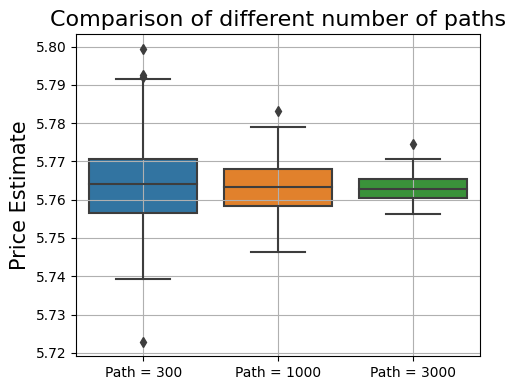

In [ ]:
data_diff_path = {}
for i in range(len(total_result_diff_path)):
    data_diff_path[f"Path = {n_simulations_list[i]}"] = total_result_diff_path[i]
data = data_diff_path
data_long_format = pd.DataFrame(list(data.items()), columns=['Simulation method', 'Price Estimate']).explode('Price Estimate')
data_long_format['Price Estimate'] = data_long_format['Price Estimate'].astype(float)

plt.figure(figsize=(5, 4))
sns.boxplot(x='Simulation method', y='Price Estimate', data=data_long_format)
plt.title('Comparison of different number of paths', fontsize = 16)
plt.xlabel('')
plt.ylabel('Price Estimate', fontsize = 15)
plt.grid(True)
plt.tight_layout()
plt.savefig('Figures/4.3.2 diff_path.png', dpi=500, bbox_inches='tight')
plt.show()

Different strike

In [ ]:
S0 = 100              
T = 1          
r = 0.05       
sigma = 0.2    
N = 10000     
n_simulations = 100 
Ks = np.linspace(80,150,8)

geometric_asian_call_theoretical = geometric_asian_call_price(S0, K, T, r, sigma, N)

total_result_diff_K = []
for K in Ks:
    # Run simulation 100 times
    results_adjusted = []
    simulation_time_cv = 100
    for _ in range(simulation_time_cv):
        mean_arithmetic, adjusted_estimate = control_variates_simulation(S0, K, T, r, sigma, N, n_simulations)
        results_adjusted.append(adjusted_estimate)
    total_result_diff_K.append(results_adjusted)

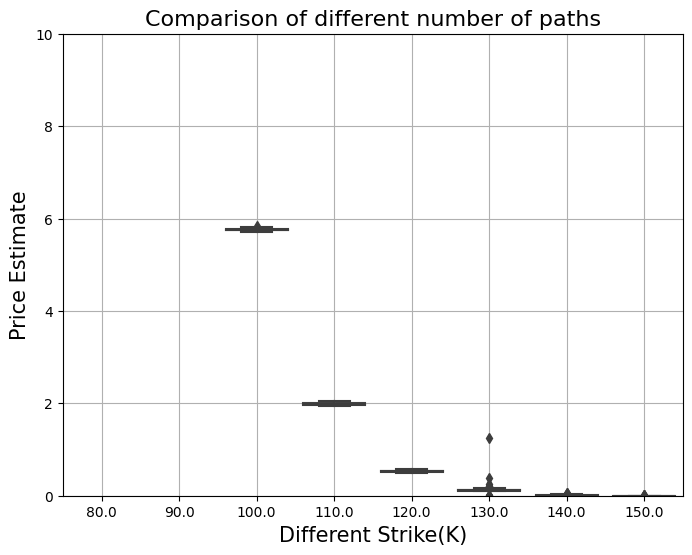

In [ ]:
data_diff_K = {}
for i in range(len(total_result_diff_K)):
    data_diff_K[f"{Ks[i]}"] = total_result_diff_K[i]
data = data_diff_K
data_long_format = pd.DataFrame(list(data.items()), columns=['Simulation method', 'Price Estimate']).explode('Price Estimate')
data_long_format['Price Estimate'] = data_long_format['Price Estimate'].astype(float)

plt.figure(figsize=(8, 6))
sns.boxplot(x='Simulation method', y='Price Estimate', data=data_long_format)
plt.title('Comparison of different number of paths', fontsize = 16)
plt.xlabel('Different Strike(K)', fontsize = 15)
plt.ylabel('Price Estimate', fontsize = 15)
plt.ylim(0,10)
plt.grid(True)
plt.show()

In [ ]:
data_diff_K_table = []
for i, j in zip(total_result_diff_K, Ks):
    data_i = {"K":j,
              "Mean":round(np.mean(i),5),
              "Variance":round(np.var(i),5)
              }
    data_diff_K_table.append(data_i)

df = pd.DataFrame(data_diff_K_table)

pd.set_option('display.float_format', '{:.4f}'.format) 

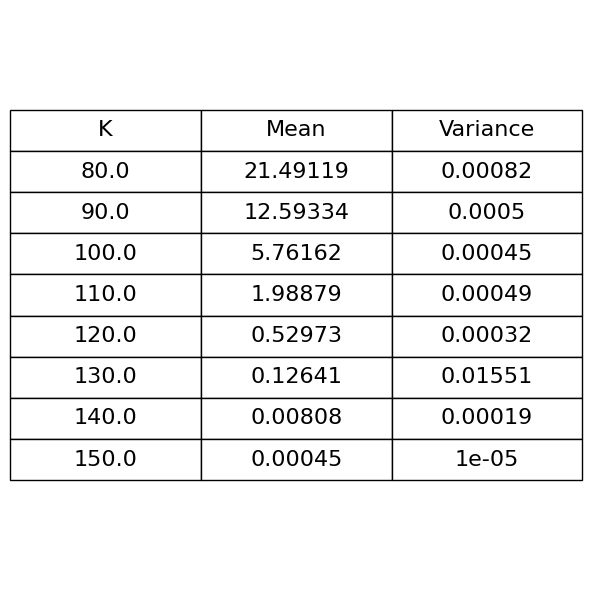

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))  
ax.axis('off')
ax.axis('tight')

tab = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
tab.auto_set_font_size(False)
tab.set_fontsize(16)
tab.scale(1.2, 2)

plt.tight_layout()
plt.savefig('Figures/4.3.2_table_compare_K.png', dpi=500, bbox_inches='tight')
plt.show()

Different number of time points used in the average

In [ ]:
S0 = 100       
K = 100        
T = 1          
r = 0.05       
sigma = 0.2    
Ns = [100, 200, 300, 1000, 3000, 10000, 30000]      
n_simulations = 1000 

geometric_asian_call_theoretical = geometric_asian_call_price(S0, K, T, r, sigma, N)

total_result_diff_tpoints = []
for N in Ns:
    results_adjusted = []
    simulation_time_cv = 100
    for _ in range(simulation_time_cv):
        mean_arithmetic, adjusted_estimate = control_variates_simulation(S0, K, T, r, sigma, N, n_simulations)
        results_adjusted.append(adjusted_estimate)
    total_result_diff_tpoints.append(results_adjusted)

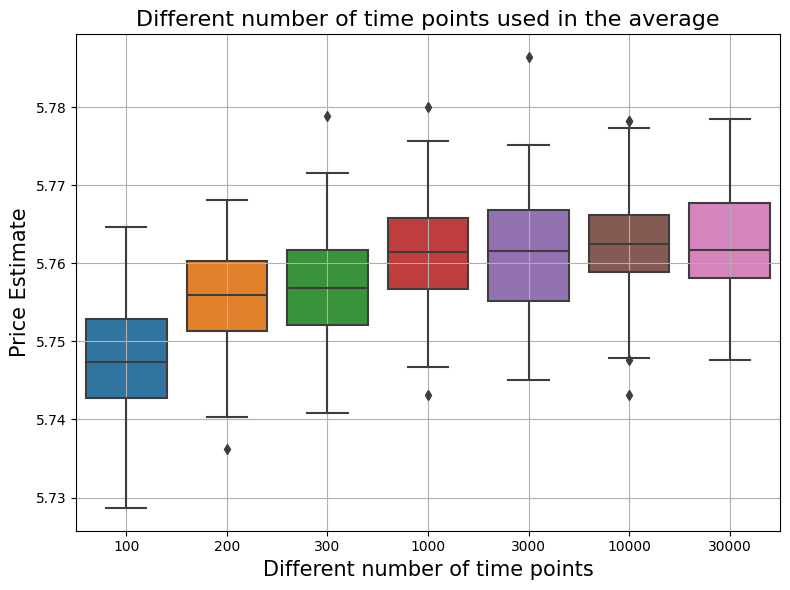

In [ ]:
data_diff_tpoints = {}
for i in range(len(total_result_diff_tpoints)):
    data_diff_tpoints[f"{Ns[i]}"] = total_result_diff_tpoints[i]
data = data_diff_tpoints
data_long_format = pd.DataFrame(list(data.items()), columns=['Simulation method', 'Price Estimate']).explode('Price Estimate')
data_long_format['Price Estimate'] = data_long_format['Price Estimate'].astype(float)

plt.figure(figsize=(8, 6))
sns.boxplot(x='Simulation method', y='Price Estimate', data=data_long_format)
plt.title('Different number of time points used in the average', fontsize = 16)
plt.xlabel('Different number of time points', fontsize = 15)
plt.ylabel('Price Estimate', fontsize = 15)
plt.grid(True)
plt.tight_layout()
plt.savefig('Figures/4.3.2_Different number of time points.png', dpi=500, bbox_inches='tight')
plt.show()